# Objective
The objetive of this notebook is to replicate example of section 12.4 https://otexts.com/fpp3/nnetar.html.

# Description of the data
The dataset contais data about sun spots. The surface of the sun contains magnetic regions that appear as dark spots. 

# Imports, configuration and constants

In [2]:
from os import path
from typing import Optional
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.neural_network import MLPRegressor

plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=13)

In [2]:
PLOT_TITLE = "Yearly sunspots"
PLOT_YLABEL = "Counts"
PLOT_XLABEL = "Year"

# Functions

In [3]:
def plot_sunspots_ts(
    ts: pd.Series, 
    start_time: str = None, 
    end_time: str = None,
    lower_ci: pd.Series = None, 
    upper_ci: pd.Series = None
):
    
    if start_time is not None:
        ts = ts[ts.index >= start_time]
        lower_ci = lower_ci[ts.index]
        upper_ci = upper_ci[ts.index]
        
    if end_time is not None:
        ts = ts[ts.index <= end_time]
        lower_ci = lower_ci[ts.index]
        upper_ci = upper_ci[ts.index]
    
    x = ts.index
    y = ts
    
    plt.plot(x, y)
    
    if lower_ci is not None and upper_ci is not None:
        plt.fill_between(x, lower_ci, upper_ci, alpha=0.2, label='Confidence Interval')
        plt.legend(loc='upper left')
    
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    plt.show()
    

def _filter_time_series(
    ts: pd.Series, 
    start_time: str = None, 
    end_time: str = None
) -> pd.Series:
        
    if start_time is not None:
        ts = ts[ts.index >= start_time]
    if end_time is not None:
        ts = ts[ts.index <= end_time]
    return ts 


def _prepare_labels(n_ts: int, labels: Optional[list[str]]) -> list[str]:
    """
    Create labels if they are None.
    """

    if labels:
        return labels

    labels = list()
    for i in range(n_ts):
        labels.append(f'TS {i+1}')

    return labels


def _get_color(index: int) -> str:
    """
    Get a color based on an index.
    """
    colors = ['k', 'b', 'r', 'g', 'c', 'm', 'y']
    return colors[index % len(colors)]


def _plot_single_ts_on_axis(
    ax: plt.Axes, 
    ts: pd.Series, 
    color: str, 
    label: str,
    lower_ci: pd.Series = None, 
    upper_ci: pd.Series = None,
):
    """
    Plot a time series and CI on an axis with a given color and label.
    """
    
    ax.plot(ts.index, ts.values, color=color, label=label)
    
    if lower_ci is not None and upper_ci is not None:
        ax.fill_between(
            ts.index, 
            lower_ci, 
            upper_ci, 
            alpha=0.2, 
            color=color, 
            label=f'{label} Confidence Interval'
        )
        
def _set_plot_properties(add_legend=True):
    """
    Set properties for the plot.
    """
    
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    
    if add_legend:
        plt.legend(loc='upper left')
        
        
def plot_multiple_ts(
    ts_list: list[pd.Series],
    start_time: str = None,
    end_time: str = None,
    lower_ci_list: Optional[list[pd.Series]] = None,
    upper_ci_list: Optional[list[pd.Series]] = None,
    labels: Optional[list[str]] = None,
):
    """
    Plot multiple time series predictions with their respective confidence intervals on the same plot.
    """
    
    labels = _prepare_labels(len(ts_list), labels)
    
    fig, ax = plt.subplots()
    
    for i in range(len(ts_list)):
        
        ts = ts_list[i]
        ts = _filter_time_series(ts, start_time, end_time)
        
        lower_ci = None
        if lower_ci_list and lower_ci_list[i] is not None:
            lower_ci = lower_ci_list[i]
            lower_ci = _filter_time_series(lower_ci, start_time, end_time)
        
        upper_ci = None
        if upper_ci_list and upper_ci_list[i] is not None:
            upper_ci = upper_ci_list[i]
            upper_ci = _filter_time_series(upper_ci, start_time, end_time)
            
        color = _get_color(i)
        label = labels[i]
        
        _plot_single_ts_on_axis(ax, ts, color, label, lower_ci, upper_ci)

    _set_plot_properties()
    plt.show()
    
    
def create_lagged_data(ts: pd.Series, N: int):
    
    # Create a DataFrame from the series
    df = pd.DataFrame(ts)
    # Shift the original data to create the lagged data
    lagged_data_df = pd.concat([df.shift(i) for i in range(N+1)], axis=1).dropna()
    lagged_data_df.columns = ['t'] + [f't-{i}' for i in range(1, N+1)]
    return lagged_data_df


def predict_iteratively(mlp: MLPRegressor, initial_data: np.array, n_preds: int) -> list[float]:
    
    predict_data = initial_data
    preds = []
    for _ in range(N_PREDS):
        pred = mlp.predict([predict_data])
        predict_data = np.hstack((pred, predict_data[:-1]))
        preds.append(pred[0])
        
    return preds

# Classes

In [4]:
class Net(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        
        super(Net, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor):
        
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

    def train(self, trainloader: DataLoader, num_epochs:int, lr: float =1e-4):
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, targets in trainloader:
                
                inputs = inputs.float()
                targets = targets.float()
                targets = targets.reshape((targets.shape[0], 1))
                
                optimizer.zero_grad()

                outputs = self(inputs)
                loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
            print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")

    def predict(self, predict_data):
        
        with torch.no_grad():
            predict_data = predict_data.float()
            outputs = self(predict_data)
            return outputs
        
    def predict_iteratively(self, initial_data: torch.Tensor, n_preds: int) -> list[float]:
    
        predict_data = initial_data

        preds = []
        for _ in range(n_preds):
            pred = self.predict(predict_data)
            predict_data = torch.cat((pred, predict_data[:-1]))
            preds.append(pred.item())

        return preds
    
    def _predict_future_path(
        self, 
        initial_data: torch.Tensor, 
        n_preds: int, 
        historical_errors: list[float]
    ) -> list[float]:

        predict_data = initial_data

        future_path = []
        for _ in range(n_preds):
            pred = self.predict(predict_data)

            hist_error = np.random.choice(historical_errors)
            hist_error = torch.Tensor([hist_error])

            future_value = pred + hist_error

            predict_data = torch.cat((future_value, predict_data[:-1]))
            future_path.append(future_value.item())

        return future_path

    def predict_future_paths(
        self, 
        n_paths: int, 
        initial_data: torch.Tensor, 
        n_preds: int, 
        historical_errors: list[float]
    ) -> list[list[float]]:

        future_paths = [
            self._predict_future_path(initial_data, n_preds, historical_errors)
            for _ in range(n_paths)
        ]

        return future_paths


class SunspotsDataset(torch.utils.data.Dataset):
    """
    Prepare the Sunsposts dataset for regression
    """

    def __init__(self, lagged_data_df: pd.DataFrame):
        
        # Split the lagged data into input and output arrays
        X = lagged_data_df.iloc[:, 1:].values
        y = lagged_data_df.iloc[:, 0].values
    
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Load data

In [5]:
data_dir_path = "../data-raw/"
sunsposts_path = path.join(data_dir_path, "sunspots.csv")

df = pd.read_csv(sunsposts_path, sep='|')
df.columns = df.columns.str.lower()

df = df.rename(columns={"index": "year", "value": "counts"})

In [6]:
df.head()

,year,counts
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0


In [7]:
ts = pd.Series(df.counts.tolist(), index=df.year)
ts.head()

year
1700     5.0
1701    11.0
1702    16.0
1703    23.0
1704    36.0
dtype: float64

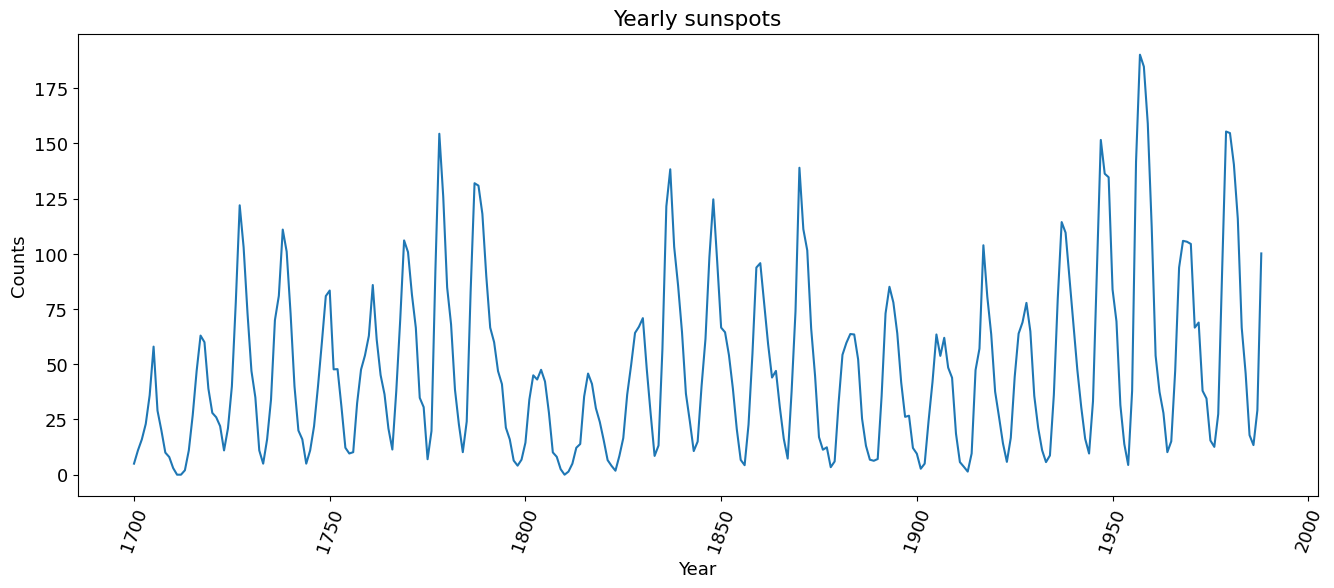

In [8]:
plot_sunspots_ts(ts)

# Forecasting
We are going tu use a multilayer perceptron with one hidden layer. The time series data values are introduced lagged to the network. In particular we are going to use a NNAR(9,5). This means the network gets as input 9 lagged values and has a hidden layer of size 5. 

We apply the sqrt as we want positive forecasts.

In [9]:
ts_sqrt = np.sqrt(ts)

In [10]:
ts_sqrt.head()

year
1700    2.236068
1701    3.316625
1702    4.000000
1703    4.795832
1704    6.000000
dtype: float64

Lets create the lagged data.

In [11]:
N_LAGS = 9
lagged_data_df = create_lagged_data(ts_sqrt, N_LAGS)

In [12]:
lagged_data_df.head()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9
year,,,,,,,,,,
1709,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000,4.795832,4.000000,3.316625,2.236068
1710,1.732051,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000,4.795832,4.000000,3.316625
1711,0.000000,1.732051,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000,4.795832,4.000000
1712,0.000000,0.000000,1.732051,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000,4.795832
1713,1.414214,0.000000,0.000000,1.732051,2.828427,3.162278,4.472136,5.385165,7.615773,6.000000


We create the datasets in a way that is friendly for Pytorch.

In [13]:
dataset = SunspotsDataset(lagged_data_df)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

Now we create the network and train it without batching.

In [14]:
# Define the input, hidden, and output sizes
input_size = N_LAGS
hidden_size = 5
output_size = 1

# Create an instance of the neural network
net = Net(input_size, hidden_size, output_size)

In [15]:
n_epochs = 100
lr = 1e-3

net.train(trainloader, n_epochs, lr=lr)

Epoch 1, loss: 17.267995780632088
Epoch 2, loss: 6.2616277433130465
Epoch 3, loss: 3.653426734892959
Epoch 4, loss: 2.4855986699176618
Epoch 5, loss: 2.1981199669116123
Epoch 6, loss: 2.0963283867971736
Epoch 7, loss: 2.023098978246019
Epoch 8, loss: 1.9559329544988682
Epoch 9, loss: 1.8963276613616245
Epoch 10, loss: 1.8420542081442883
Epoch 11, loss: 1.7922413612714991
Epoch 12, loss: 1.7464316379362053
Epoch 13, loss: 1.704321662291282
Epoch 14, loss: 1.6656397386072577
Epoch 15, loss: 1.6300745194498762
Epoch 16, loss: 1.5973988143789557
Epoch 17, loss: 1.5703723120650857
Epoch 18, loss: 1.54341304136746
Epoch 19, loss: 1.5186250754244481
Epoch 20, loss: 1.4960008369551263
Epoch 21, loss: 1.4791899776822641
Epoch 22, loss: 1.461189560523412
Epoch 23, loss: 1.4415676613400656
Epoch 24, loss: 1.4241194739462637
Epoch 25, loss: 1.4067782026576587
Epoch 26, loss: 1.3930015683783625
Epoch 27, loss: 1.3801394336206354
Epoch 28, loss: 1.3683091029076813
Epoch 29, loss: 1.3573377012559442


We create the initial data for the iterative prediction. We use the last values of the series.

In [16]:
lagged_data_df.tail()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9
year,,,,,,,,,,
1984,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044,3.549648,3.937004
1985,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044,3.549648
1986,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692,5.244044
1987,5.403702,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954,9.617692
1988,10.009995,5.403702,3.660601,4.230839,6.774954,8.160882,10.765686,11.853270,12.437845,12.465954


In [17]:
initial_data = torch.from_numpy(np.array(lagged_data_df.iloc[-1][:-1]))
initial_data

tensor([10.0100,  5.4037,  3.6606,  4.2308,  6.7750,  8.1609, 10.7657, 11.8533,
        12.4378], dtype=torch.float64)

We predict iteratively, that means that we use the obtained prediction to update the input of the network.

In [18]:
N_PREDS = 30
preds = net.predict_iteratively(initial_data, N_PREDS)

Creation of the final forecasts.

In [19]:
last_year = lagged_data_df.index[-1]
h_index = range(last_year+1, last_year+N_PREDS+1)

ts_h = np.power(pd.Series(preds, index=h_index), 2)
ts_with_h = pd.concat([ts, ts_h])

As in the book, this model has modelled the cyclicity of the data well.

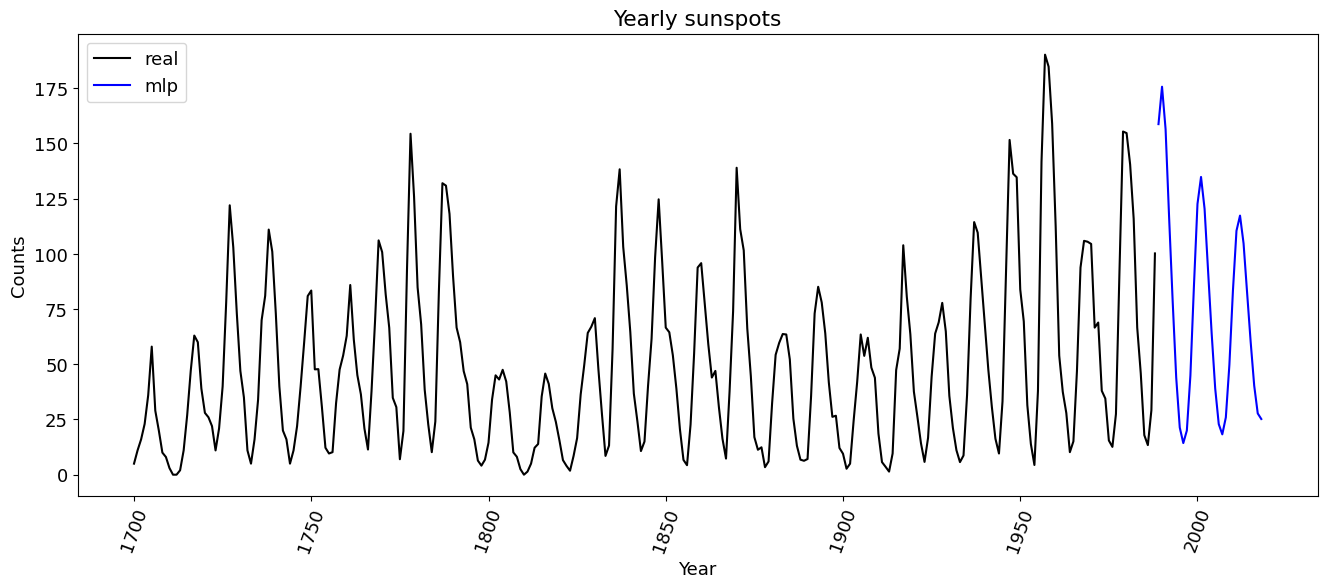

In [20]:
labels = ["real", "mlp",]

plot_multiple_ts([ts, ts_h], labels=labels)

### Checking that a sklearn does a similar job
Instead of using Pytorch, we repeat the experiment with sklearn to ensure that our network was well-constructed. As we can see the results are indeed similar.

In [21]:
X = dataset.X.numpy()
y = dataset.y.numpy()

mlp = MLPRegressor(
    # random_state=1, 
    max_iter=n_epochs, 
    hidden_layer_sizes=(hidden_size,),
    learning_rate_init=lr,
    batch_size=1
)

mlp.fit(X, y);

/home/santiagopalmero/.pyenv/versions/3.10.5/envs/fpp3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
mlp_initial_data = np.array(lagged_data_df.iloc[-1][:-1])
mlp_preds = predict_iteratively(mlp, mlp_initial_data, N_PREDS)
ts_mlp_h = np.power(pd.Series(mlp_preds, index=h_index), 2)

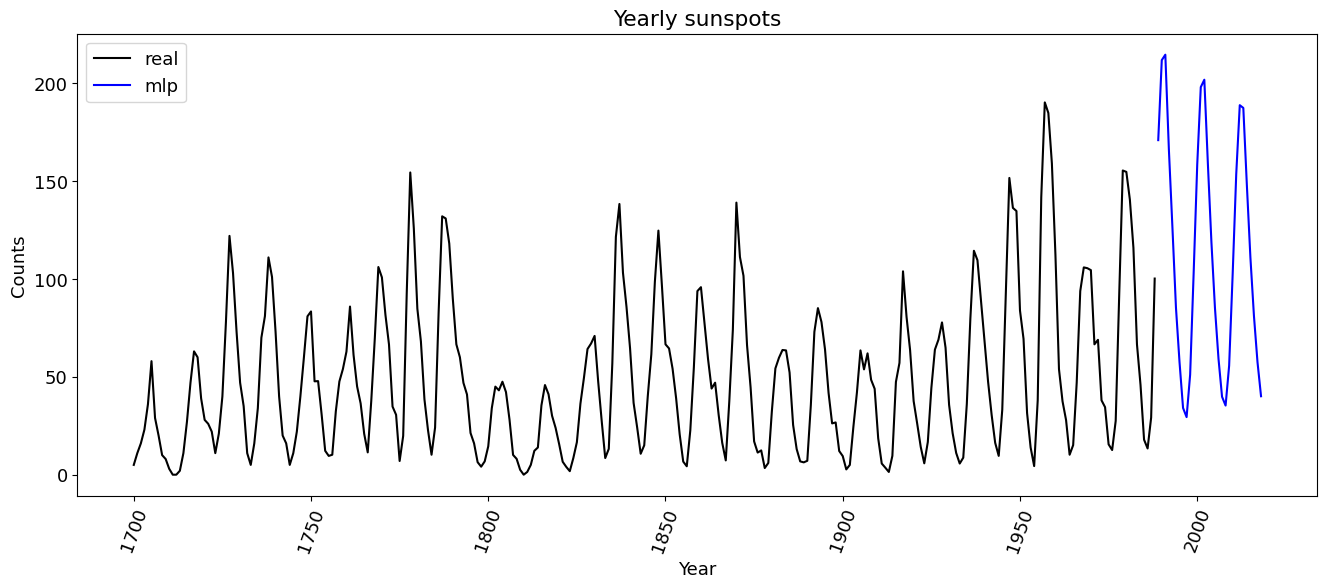

In [23]:
plot_multiple_ts([ts, ts_mlp_h], labels=labels)

### Future paths

As explained in https://otexts.com/fpp3/nnetar.html#prediction-intervals-5 and https://otexts.com/fpp3/prediction-intervals.html#prediction-intervals-from-bootstrapped-residuals we are going to assume that the residuals are uncorrelated with constant variance. Under this assumption we are going to sample past errors (the residuals) and use them to simulate future sample paths and obtain prediction intervals. 

In [24]:
# Get a sample of historical errors
historical_errors = []
for inputs, targets in trainloader:
    outputs = net.predict(inputs)
    
    error = targets.item() - outputs.item()
    historical_errors.append(error)

In [25]:
future_paths = net.predict_future_paths(5, initial_data, N_PREDS, historical_errors)

Create the final forecasts for each of the future paths.

In [26]:
ts_futures_h = []
for future_path in future_paths:
    ts_future_h = np.power(pd.Series(future_path, index=h_index), 2)
    
    ts_futures_h.append(ts_future_h)

Visualize all paths.

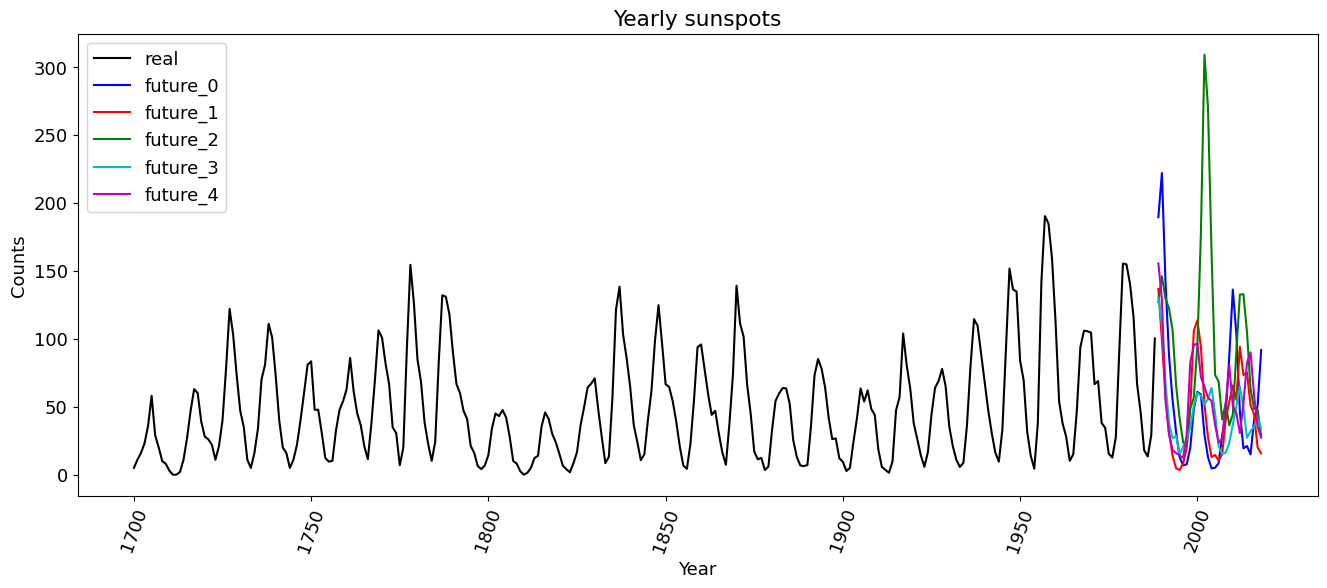

In [27]:
labels = ["real"] + [f"future_{i}" for i in range(5)]

plot_multiple_ts([ts] + ts_futures_h, labels=labels)

As a extra we are going to compute confidence intervals by calculating percentiles of the future sample paths for each forecast horizon as mentioned in https://otexts.com/fpp3/prediction-intervals.html#prediction-intervals-from-bootstrapped-residuals. We generate a larger amount of paths so that the intervals are smoother.

In [28]:
future_paths = net.predict_future_paths(500, initial_data, N_PREDS, historical_errors)

In [29]:
lower_bound = np.percentile(future_paths, 2.5, axis=0)
upper_bound = np.percentile(future_paths, 97.5, axis=0)
means = np.mean(np.array(future_paths), axis=0)

ts_lower_h = np.power(pd.Series(lower_bound, index=h_index), 2)
ts_upper_h = np.power(pd.Series(upper_bound, index=h_index), 2)
ts_h = np.power(pd.Series(means, index=h_index), 2)

Our results are similar to the ones in the book.

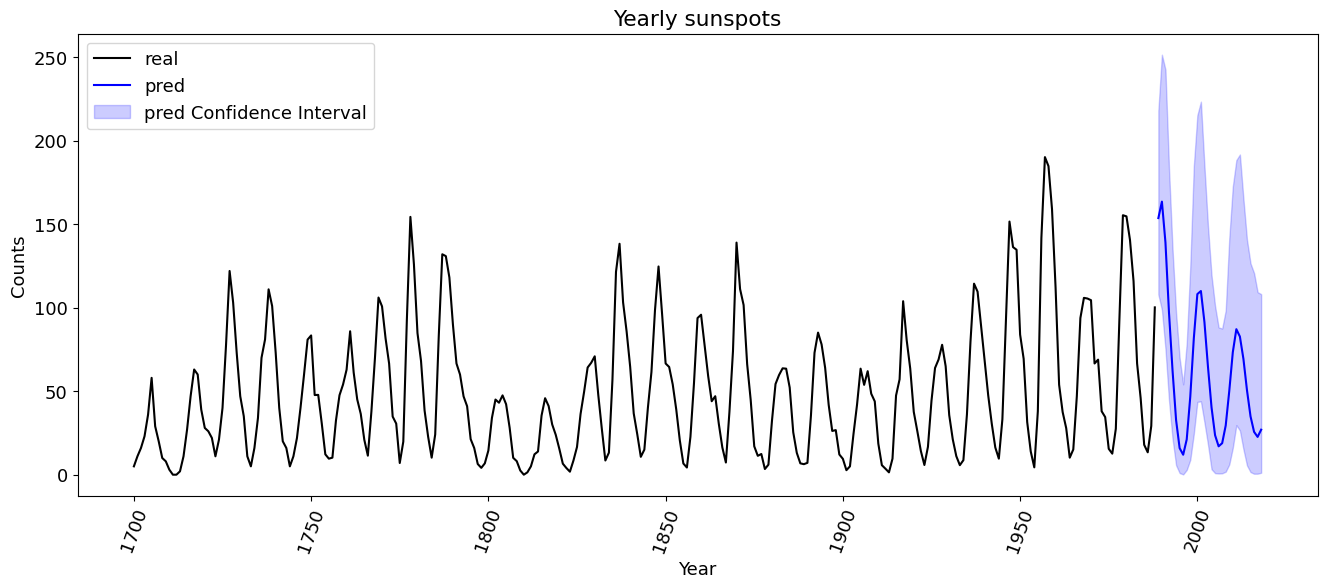

In [30]:
plot_multiple_ts(
    [ts, ts_h], 
    labels=["real", "pred"],
    lower_ci_list=[None, ts_lower_h],
    upper_ci_list=[None, ts_upper_h],
)